In [36]:
#import scvi
import scanpy as sc
import pandas as pd
import numpy as np

In [29]:
import matplotlib.pyplot as plt

In [30]:
import anndata

In [31]:
import random

In [32]:
import os

In [ ]:
import seaborn as sns

#### Load data

In [23]:
adata = sc.read('pb_12_donors.h5ad')

In [17]:
adata.obs['label'] = adata.obs['subset']

In [19]:
random_unknown_cells = random.sample(list(adata[adata.obs['label'] != 'Unknown'].obs.index.to_numpy()), 3208) ## 15 percent randomly of the known set to unknown (validation set)

In [20]:
adata.obs['label'] = [x if not y in random_unknown_cells else 'Unknown' for x,y in zip(adata.obs['label'], adata.obs.index)]

In [22]:
adata.obs['dataset'] = [x.split('_')[0][:-1] for x in adata.obs['batch']]

#### Before integration

In [39]:
adata_bulk = adata[adata.obs['subset'] == 'Unknown'].copy()

In [40]:
#adata.layers["counts"] = adata.X.copy()
#adata.raw = adata  # keep full dimension safe
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata_bulk)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    layer="counts",
    batch_key="batch",
    subset=True
)

In [41]:
sc.pp.pca(adata_bulk)

In [51]:
adata.uns['batch_colors'] = ['#16364F', '#295F89', '#3B85C3', '#76AAD4', '#B0CEE6', 
'#B62025', '#EC5E61', '#F4A2A4',
'#CA6728', '#FAB166',
'#80438A', '#BB86BB']

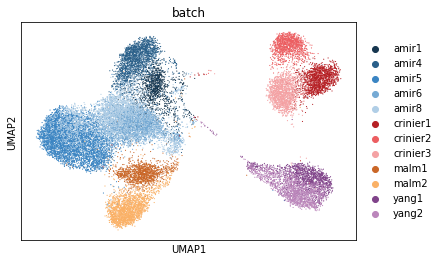

In [55]:
sc.pl.umap(adata, color='batch', save='blood_samples_before_integration.pdf')

#### Train scVI model

In [67]:
scvi.model.SCVI.setup_anndata(adata,
                                batch_key='batch',
                                labels_key='label')#,

In [68]:
scvi_model = scvi.model.SCVI(adata,
                        n_latent=40,
                        n_layers=2,
                        gene_likelihood = "nb")

In [69]:
scvi_model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 179/179: 100%|██████████| 179/179 [10:35<00:00,  3.55s/it, loss=2.51e+03, v_num=1]


In [70]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

In [71]:
sc.pp.neighbors(adata, use_rep="X_scVI")

In [72]:
sc.tl.umap(adata)

In [ ]:
sc.tl.leiden(adata)

#### Train scANVI model

In [74]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model,
                                                 adata=adata,
                                                 unlabeled_category='Unknown')

In [75]:
scanvi_epochs = 100
train_kwargs_scanvi = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [76]:
scanvi_model.train(
    max_epochs=scanvi_epochs,
    **train_kwargs_scanvi
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 11/100:  11%|█         | 11/100 [01:32<12:31,  8.45s/it, loss=2.56e+03, v_num=1]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 2575.219. Signaling Trainer to stop.


In [78]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [79]:
adata.obs['C_scANVI'] = scanvi_model.predict(adata)

In [ ]:
adata.obs['subset'].cat.reorder_categories(['CD56bright', 'NKG2A+', 'KIR+', 'CD57+', 'Adaptive', 'Unknown'], inplace=True)

In [ ]:
adata.obs['C_scANVI'].cat.reorder_categories(['CD56bright', 'NKG2A+', 'KIR+', 'CD57+', 'Adaptive'], inplace=True)

In [83]:
df = adata[np.logical_and(adata.obs['subset'] != 'Unknown', adata.obs['label'] == 'Unknown')].obs.groupby(['subset', 'C_scANVI']).size().unstack(fill_value=0)

In [165]:
df = adata[adata.obs['subset'] != 'Unknown'].obs.groupby(['subset', 'C_scANVI']).size().unstack(fill_value=0)

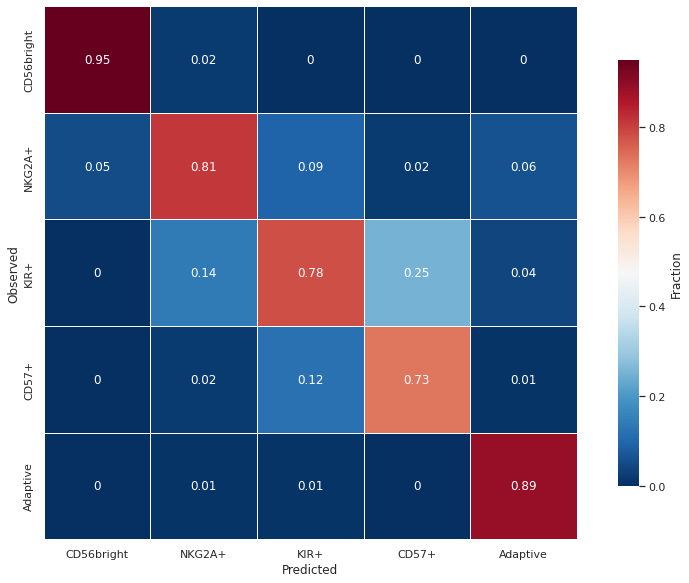

In [127]:
norm_df = df / df.sum(axis=0)
ax = sns.heatmap(norm_df.round(2), cmap='RdBu_r', xticklabels=True, yticklabels=True, square=True,
                 linecolor='white', linewidths=0.5, annot=True,
                 cbar=True, cbar_kws={'shrink': 0.8, 'pad': 0.05, 'label': 'Fraction'})
plt.tight_layout()
plt.xlabel("Predicted")
plt.ylabel("Observed")
#plt.show()
plt.savefig(os.path.join(sc.settings.figdir, 'observed_v_predicted.pdf'))

#### Save models and adata

In [25]:
scanvi_model.save('blood_ref_scanvi',  overwrite=True)

In [10]:
adata.write('pb_12_donors_processed.h5ad')

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


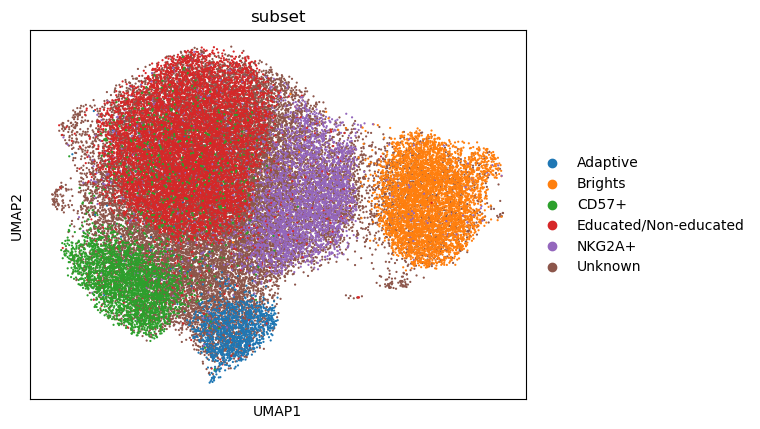

In [16]:
sc.pl.umap(adata, color='subset', s=10)

#### DE

In [ ]:
for g1,g2 in subset_pairs:
    de_df = scanvi_model.differential_expression(
        groupby="C_scANVI",
        group1=g1,
        group2=g2,
        delta=0.5,
        batch_correction=True
    )
    if g1 == 'Educated/Non-educated':
        g1 = 'ed_non_ed'
    if g2 == 'Educated/Non-educated':
        g2 = 'ed_non_ed'
    genes = list(de_df[np.logical_and(de_df['lfc_median'] > 0, de_df['raw_mean1'] > 0.5)][:3].index)+list(de_df[np.logical_and(de_df['lfc_median'] < 0, de_df['raw_mean2'] > 0.5)][:3].index)
    all_genes = all_genes + genes
    sc.pl.dotplot(adata,genes,
                   groupby='C_scANVI', 
                  categories_order=['Adaptive','CD57+','Educated/Non-educated','NKG2A+', 'Brights'],
                  save='dotplot_%s_%s_markers.pdf' % (g1,g2))

In [200]:
de_df = scanvi_model.differential_expression(
        groupby="C_scANVI",
        delta=0.15,
        batch_correction=True
    )

DE...: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]


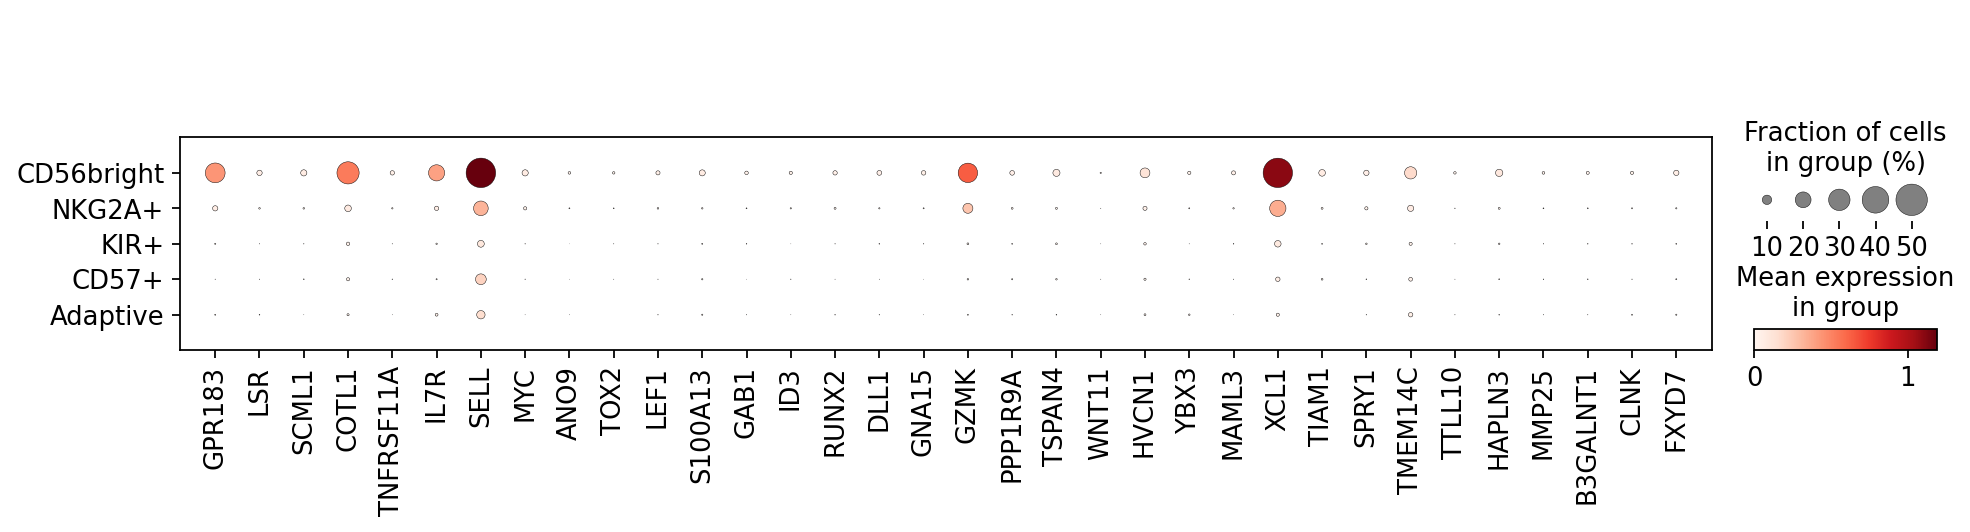

In [185]:
sc.pl.dotplot(adata_bulk, de_df_bright[(de_df_bright['proba_not_de'] < 0.05) & (de_df_bright['group1'] == 'CD56bright') & (de_df_bright['lfc_mean'] > 2)].index, groupby='C_scANVI')

#### Clustering

In [20]:
adata_psueodtime = sc.read('pb_12_donors_pseudotime.h5ad')
adata.obs['pseudotime'] = np.array(adata_blood_bulk.obs['pseudotime'])
adata.obsm['X_dm_umap'] = adata_blood_bulk.obsm['X_umap']

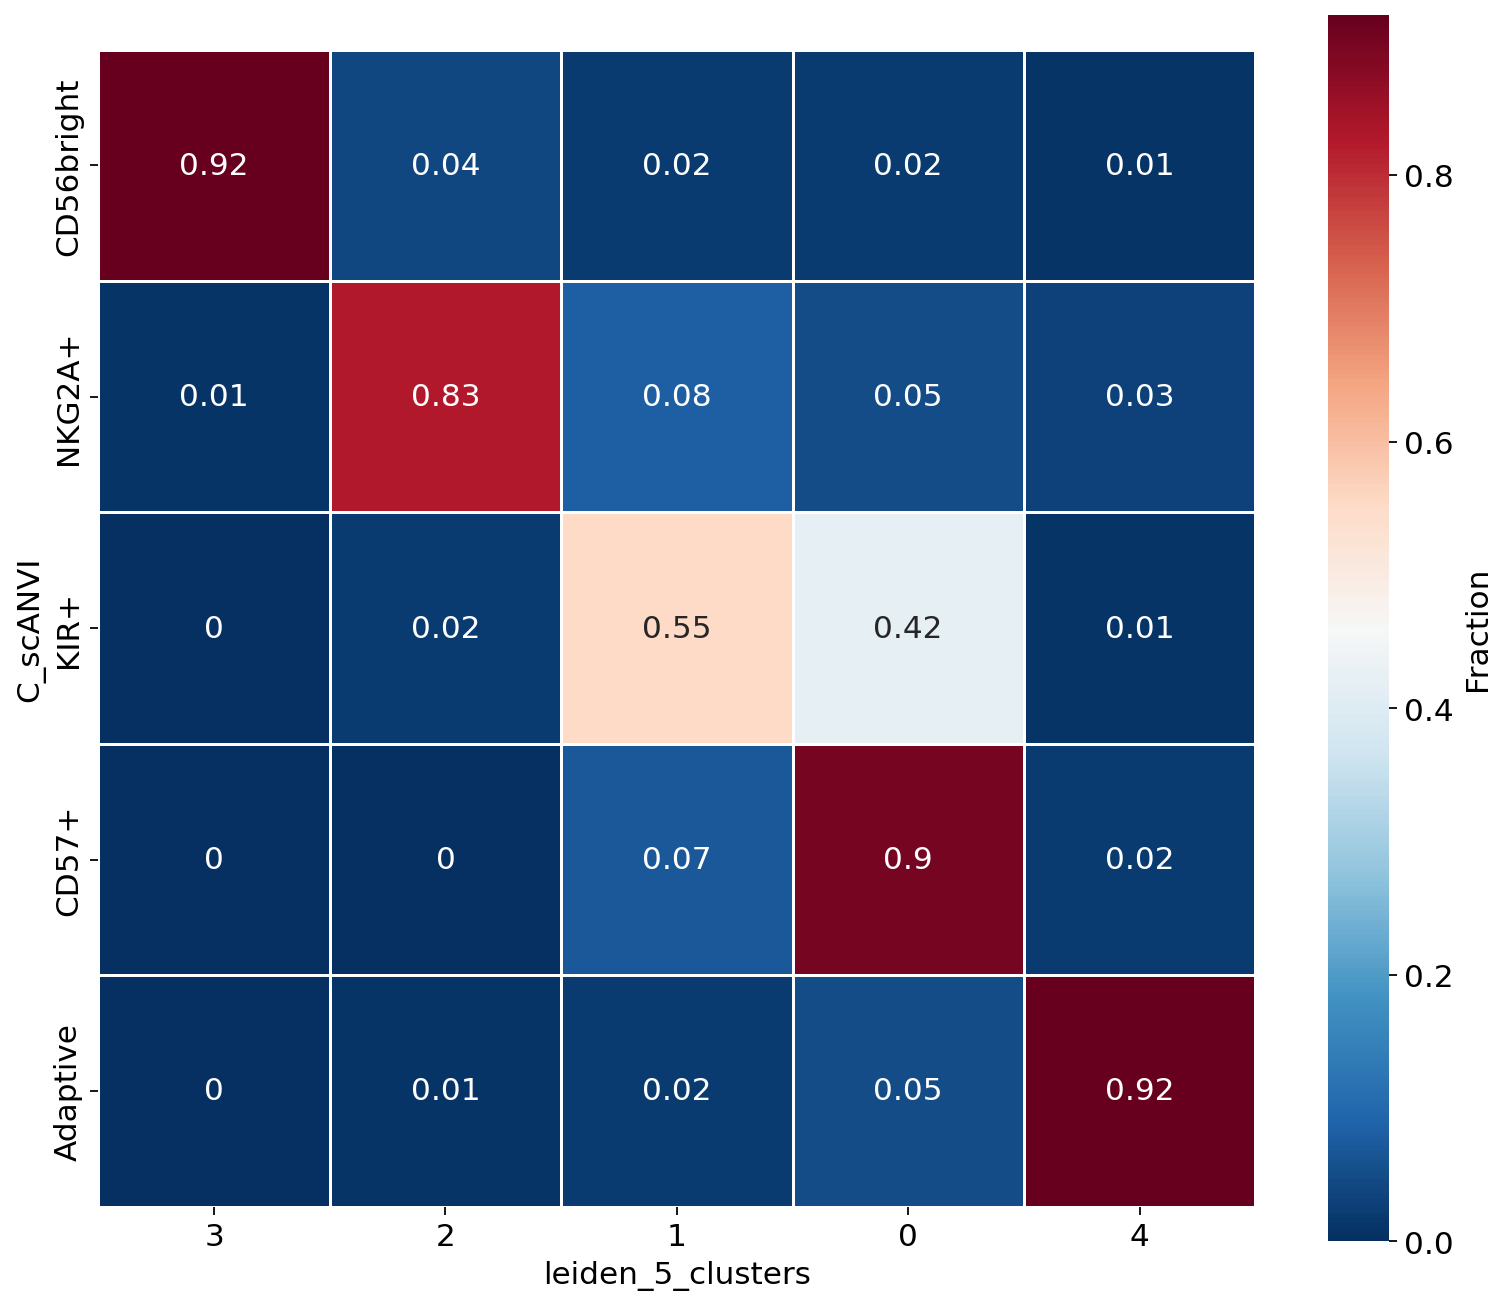

In [69]:
import scanpy as sc; import seaborn as sns
cmtx = sc.metrics.confusion_matrix("C_scANVI", "leiden", adata.obs)
#cmtx = cmtx.loc[:,['CD56bright', 'NKG2A+', 'KIR+', 'CD57+']]
ax=sns.heatmap(cmtx.round(2), cmap='RdBu_r', xticklabels=True, yticklabels=True, square=True,
                 linecolor='white', linewidths=0.5, annot=True,
                 cbar=True, cbar_kws={'shrink': 0.8, 'pad': 0.05, 'label': 'Fraction'})
plt.tight_layout()
#plt.ylabel("Our annotations (Celltypist-based)")
#plt.xlabel("Our model prediction")
plt.show()
#plt.savefig(os.path.join(sc.settings.figdir, '12donor_subset_clusters_5_clusters.pdf'))

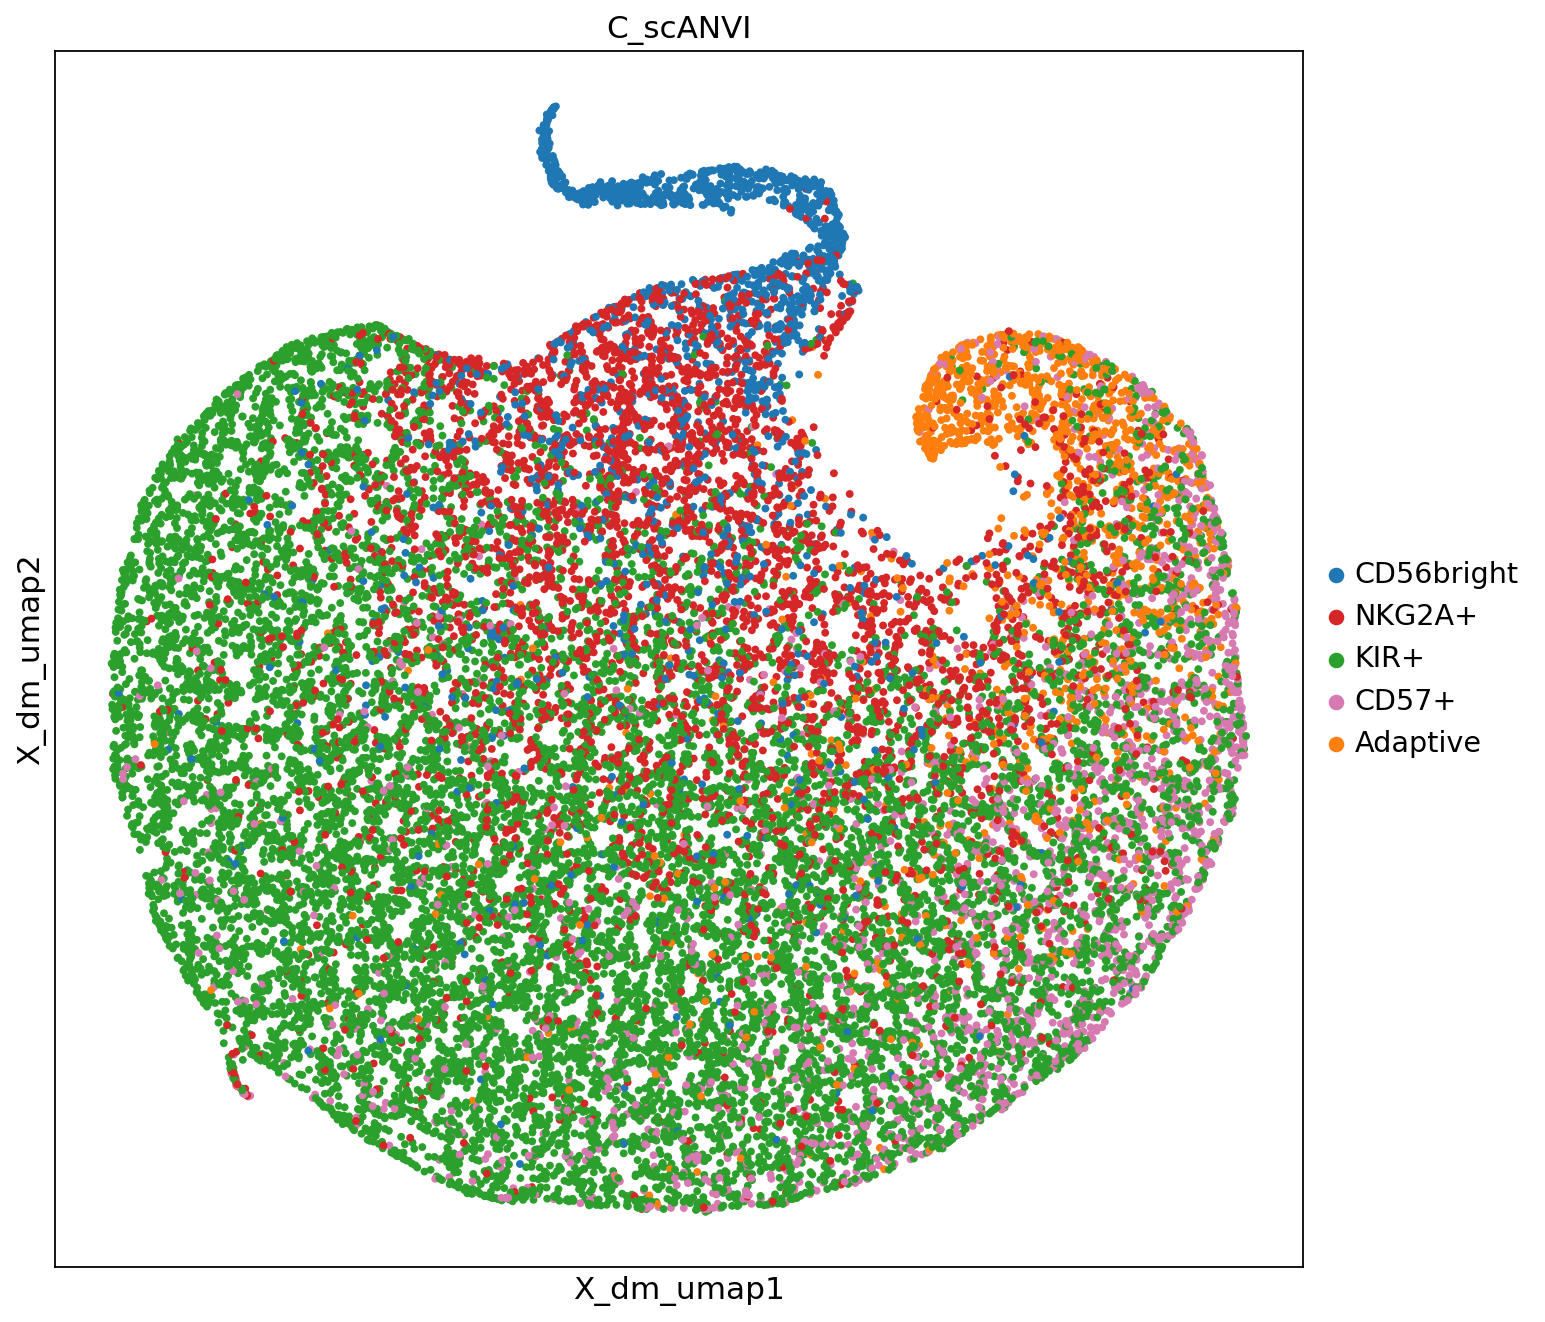

In [35]:
sc.pl.embedding(adata_bulk, basis='X_dm_umap', color='C_scANVI', s=50)

#### Signature scoring

In [124]:
for key in gene_sig:
    gene_sig[key] = [x for x in gene_sig[key] if x in adata.var_names]

In [89]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

In [111]:
adata_bulk

AnnData object with n_obs × n_vars = 23253 × 9833
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'sample', 'batch', 'subset', 'label', 'dataset', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden', 'leiden_5_clusters', 'leiden_6_clusters', 'leiden_10_clusters', 'leiden_7_clusters', 'leiden_9_clusters', 'leiden_8_clusters', 'NK1C_sig', 'NK3_sig', 'NK1A_sig', 'NK1B_sig', 'NK2B_sig', 'NK2A_sig'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_5_clusters_colors', 'leiden_6_clusters_colors', 'neighbors', 'subset_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap', 'X_dm_umap'
    obsp: 'connectivities', 'distances'

In [125]:
signature_genes = [x for x in gene_sig.values()]
#signature_names = ['CD56bright regulome', 'CD56dim regulome']

In [126]:
gene_sigs = [GeneSignature(name,gene_sig[name]) for name in gene_sig]

In [128]:
exp_df = adata.to_df()

In [129]:
import random

In [130]:
random.seed(0)

In [132]:
auc_mtx = aucell(exp_df, gene_sigs, num_workers=4)

In [134]:
adata_bulk.obs[[x + '_auc' for x in auc_mtx.columns]] = auc_mtx.to_numpy()